In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
import pickle

# 1. Load the data:

In [3]:
def load_data(train_pkl_file, test_pkl_file):
    with open(test_pkl_file, 'rb') as f:
        x_test, y_test = pickle.load(f)
    with open(train_pkl_file, 'rb') as f:
        x_train, y_train = pickle.load(f)
    return x_train, x_test, y_train, y_test


In [4]:
x_tr1, x_te1, y_tr1, y_te1 = load_data('train_data.pkl', 'test_data.pkl')
x_tr2, x_te2, y_tr2, y_te2 = load_data('train_data2.pkl', 'test_data2.pkl')

In [5]:
y_te1.shape

(836,)

# 2. Naïve Bayes models

## 2.0 Build up bayes class.

In [6]:

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [7]:
class myBayes:
  '''
  This class is my bayes class.
  '''
  def __init__(self, model, **kw):
    '''
    model: sklearn models
    **kw: any keywords in the given model
    '''
    self.model = model(**kw)

  def __call__(self, x_tr, x_te, y_tr, y_te):
    print('>>>> running')
    self.__x_tr = x_tr
    self.__x_te = x_te
    self.__y_tr = np.array(y_tr).reshape(-1,1)
    self.__y_te = np.array(y_te).reshape(-1,1)
    self.__y = np.vstack((self.__y_tr, self.__y_te))
    self.__x = np.vstack((x_tr, x_te))
    m = self.model
    m.fit(x_tr, y_tr)
    self.tr_pred = m.predict(x_tr)
    self.te_pred = m.predict(x_te)
    self.pred = m.predict(self.__x)
    self.te_score = m.predict_proba(x_tr)
    self.tr_score = m.predict_proba(x_te)
    # calculate the score:
    self.__f1_tr = f1_score(y_tr, self.tr_pred)
    self.__f1_te = f1_score(y_te, self.te_pred)
    self.__f1_all = f1_score(self.__y, self.pred)
    self.__accu_tr = accuracy_score(y_tr, self.tr_pred)
    self.__accu_te = accuracy_score(y_te, self.te_pred)
    self.__accu_all = accuracy_score(self.__y, self.pred)
    print('>>>> fitted')

  # Get the confusion matrix:
  def get_confusion_matrix(self, target = 'test'):
    '''
    Method get the confusion matrix.
    By default, this method will return the confusion matrix for test set.
    '''
    classes = ['ham', 'spam']
    if target == 'test':
      cm = confusion_matrix(self.__y_te, self.te_pred)
    else:
      cm = confusion_matrix(self.__y_tr, self.tr_pred)
    frame = pd.DataFrame(cm, columns = classes, index = classes)
    return frame

  # Method to get scores:
  def get_scores(self):
    '''
    Get the score frame.
    output: pd.DataFrame. f1 score and accuracy for both training set and test set.
    '''
    dic = {'f1_score':[self.__f1_tr, self.__f1_te, self.__f1_all], 'accuracy':[self.__accu_tr, self.__accu_te, self.__accu_all]}
    frame = pd.DataFrame(dic, index = ['Traing', 'Test', 'Whole Set'])
    return frame


  # Plot the confusion matrix
  def plot_confusion(self, target = 'test'):
    '''
    Method to plot the confusion matrix.
    By default, the method will plot the confusion matrix for the test set.
    '''
    model_name = str(self.model).split('(')[0]
    classes = ['ham', 'spam']
    if target == 'test':
      cm = confusion_matrix(self.__y_te, self.te_pred)
    else:
      cm = confusion_matrix(self.__y_tr, self.tr_pred)

    ## Draw the figure
    fig, ax = plt.subplots(figsize = (6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix for {}'.format(model_name),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('pics/{}_confusion_matrix.png'.format(model_name))
    plt.show()

    # Plot Roc curve:
    def ROC(self):
      '''
      This method helps to return the ROC of the model.
      '''
      

## 2.1 Gaussian Naïve Bayes:

Gaussian naïve Bayes does not take sparse as an valid input since it is not designed to make prediction on text data because very sarse data seldomly fullfill the assumption of the model. But to make comnparison anyway, I change the sparse matrix to numpy array

This method is also time-consuming.

In [8]:
gnb1 = myBayes(GaussianNB)
gnb1(x_tr1.toarray(), x_te1.toarray(), y_tr1, y_te1)

gnb2 = myBayes(GaussianNB)
gnb2(x_tr2.toarray(), x_te2.toarray(), y_tr2, y_te2)

>>>> running
>>>> fitted
>>>> running
>>>> fitted


In [9]:
gnb1.get_scores()

,f1_score,accuracy
Traing,0.971378,0.951858
Test,0.927790,0.881579
Whole Set,0.964978,0.941314


In [10]:
gnb2.get_scores()

,f1_score,accuracy
Traing,0.971378,0.951858
Test,0.927895,0.881579
Whole Set,0.964986,0.941314


In [11]:
gnb1.get_confusion_matrix()

,ham,spam
ham,101,7
spam,92,636


In [12]:
gnb1.get_confusion_matrix(target='training')

,ham,spam
ham,639,0
spam,228,3869


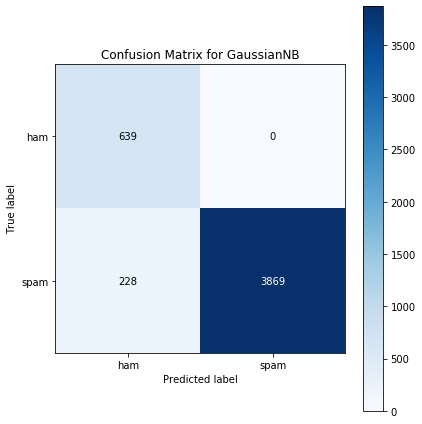

In [13]:
gnb1.plot_confusion(target = 'training')

## 2.2 Multinomial Naïve Bayes

In [14]:
# Fit 2 models by using two data sets generlized by different vectorizer.
mnb1 = myBayes(MultinomialNB)
mnb1(x_tr1.toarray(), x_te1.toarray(), y_tr1, y_te1)

mnb2 = myBayes(MultinomialNB)
mnb2(x_tr2.toarray(), x_te2.toarray(), y_tr2, y_te2)

>>>> running
>>>> fitted
>>>> running
>>>> fitted


In [15]:
# Get the scores for the first MNB model.
mnb1.get_scores()

,f1_score,accuracy
Traing,0.996339,0.993666
Test,0.985507,0.974880
Whole Set,0.994711,0.990847


In [16]:
# Get the scores for the second MNB model.
mnb2.get_scores()

,f1_score,accuracy
Traing,0.986635,0.976562
Test,0.983784,0.971292
Whole Set,0.986203,0.975772


Based on the scores above, the first vectorizer performs slightly better than  the second one, still. And the highest test and overall f1 scores come from the mnb1.


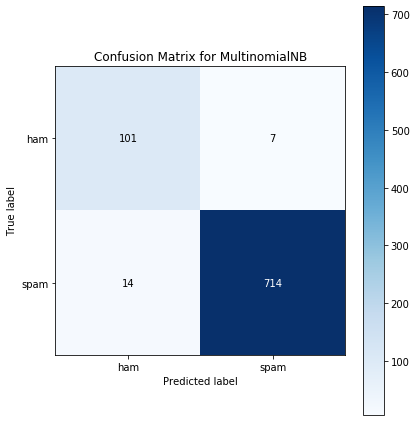

In [17]:
mnb1.plot_confusion()
plt.show()

## 2.3 Bernoulli naïve Bayes

Similar to the procedures in section 2.2, 2.3, I will still fit 2 models based on different vectorizer and try to tell the which one is more suitable.

In [18]:
# Fit models.
bnb1 = myBayes(BernoulliNB)
bnb1(x_tr1.toarray(), x_te1.toarray(), y_tr1, y_te1)

bnb2 = myBayes(BernoulliNB)
bnb2(x_tr2.toarray(), x_te2.toarray(), y_tr2, y_te2)

>>>> running
>>>> fitted
>>>> running
>>>> fitted


In [19]:
# Get the scores for the 1st model.
bnb1.get_scores()

,f1_score,accuracy
Traing,0.990204,0.982897
Test,0.985705,0.974880
Whole Set,0.989526,0.981694


In [20]:
# Get the score for 2nd model.
bnb2.get_scores()

,f1_score,accuracy
Traing,0.990204,0.982897
Test,0.985705,0.974880
Whole Set,0.989526,0.981694


As the scores showed above, two vectorizer does not make obvious differeces, and the second BNB performs better than MNB2 with respect to f1 score over the whole data set.

Since both models perform in a same manner, I will just show confusion matrix for the second model.

In [21]:
bnb2.get_confusion_matrix()

,ham,spam
ham,91,17
spam,4,724


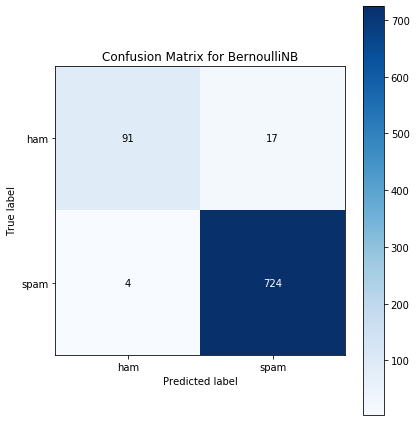

In [22]:
bnb2.plot_confusion()

## 3. Final model: MNB1, BNB2

Based on the output above, the best using the first vectorizer is Multinomial naïve Bayes.

The one perform best on the second vectorizer is Bernulli naïve Bayes.



In [23]:
# Give the final model.
# Count vect:
mnb1 = myBayes(MultinomialNB)
mnb1(x_tr1.toarray(), x_te1.toarray(), y_tr1, y_te1)

# Tfid vect:
bnb2 = myBayes(BernoulliNB)
bnb2(x_tr2.toarray(), x_te2.toarray(), y_tr2, y_te2)

>>>> running
>>>> fitted
>>>> running
>>>> fitted


In [24]:
with open('bayes_model/MNB1.pkl', 'wb') as f:
    pickle.dump(mnb1.model, f)
with open('bayes_model/BNB2.pkl', 'wb') as f:
    pickle.dump(bnb2.model, f)